##Import

In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm.auto import tqdm
import csv

##Downloading Files

In [2]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
    annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder

In [3]:
annotation_file = './annotations/captions_train2014.json'

PATH = './train2014/'

In [ ]:
##Limitting Training set

In [4]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [18]:
len(train_captions), len(all_captions)

(30000, 414113)

In [ ]:
##Image Processing

In [6]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [11]:
!pip install -q tqdm

In [8]:
from tqdm import tqdm

In [9]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 1622/1622 [03:58<00:00,  6.79it/s]


In [10]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [11]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [12]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [13]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [14]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [15]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

##partitioning Test and train split 80-20

In [16]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.0333,
                                                                    random_state=0)

In [17]:
len(img_name_train), len(img_name_val)

(29000, 1000)

In [19]:
# Feel free to change these parameters according to your system's configuration
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [20]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [22]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [23]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [24]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)
    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [25]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [26]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

##Check Points

In [27]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [28]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [29]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

#Model

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

##Training Model

In [33]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.8391
Epoch 1 Batch 100 Loss 0.8410
Epoch 1 Batch 200 Loss 0.7907
Epoch 1 Batch 300 Loss 0.8115
Epoch 1 Batch 400 Loss 0.7945
Epoch 1 Loss 0.798972
Time taken for 1 epoch 278.311639547348 sec

Epoch 2 Batch 0 Loss 0.6399
Epoch 2 Batch 100 Loss 0.7181
Epoch 2 Batch 200 Loss 0.5872
Epoch 2 Batch 300 Loss 0.6077
Epoch 2 Batch 400 Loss 0.7169
Epoch 2 Loss 0.660645
Time taken for 1 epoch 352.5573251247406 sec

Epoch 3 Batch 0 Loss 0.5890
Epoch 3 Batch 100 Loss 0.5851
Epoch 3 Batch 200 Loss 0.6139
Epoch 3 Batch 300 Loss 0.5286
Epoch 3 Batch 400 Loss 0.6223
Epoch 3 Loss 0.581132
Time taken for 1 epoch 462.14094710350037 sec

Epoch 4 Batch 0 Loss 0.5496
Epoch 4 Batch 100 Loss 0.5376
Epoch 4 Batch 200 Loss 0.5471
Epoch 4 Batch 300 Loss 0.5308
Epoch 4 Batch 400 Loss 0.5115
Epoch 4 Loss 0.520221
Time taken for 1 epoch 682.7867505550385 sec

Epoch 5 Batch 0 Loss 0.4598
Epoch 5 Batch 100 Loss 0.4647
Epoch 5 Batch 200 Loss 0.4718
Epoch 5 Batch 300 Loss 0.4449
Epoch 5 Batch 400 

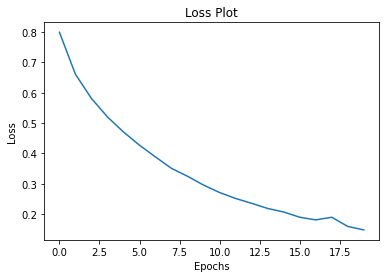

In [34]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

##Prediction

In [88]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def evaluate_without_plot(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [73]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [36]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> the table in the small apartment is set for one person <end>
Prediction Caption: a picture of people having a <unk> chairs and dining table <end>


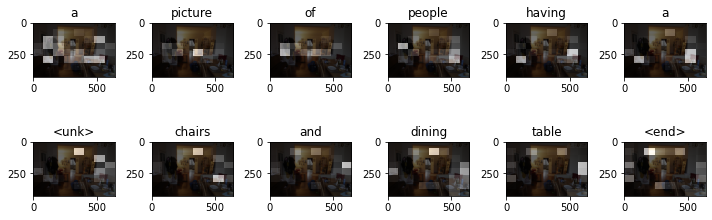

In [37]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [ ]:
#Storing All Caption File

In [ ]:
real_captions = []
pred_captions = []

with open('./all_captions.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(["true_caption", "pred_caption"])

    for idx in tqdm(range(len(img_name_val))):
        r_cap = [tokenizer.index_word[i] for i in cap_val[idx] if i not in [0]][1:-1]
        p_cap = evaluate_without_plot(img_name_val[idx])[:-1]
    
        real_captions.append(r_cap)
        pred_captions.append(p_cap)

        writer.writerow([' '.join(r_cap), ' '.join(p_cap)])

Prediction Caption: a surfer makes a surfboard atop a wave <end>


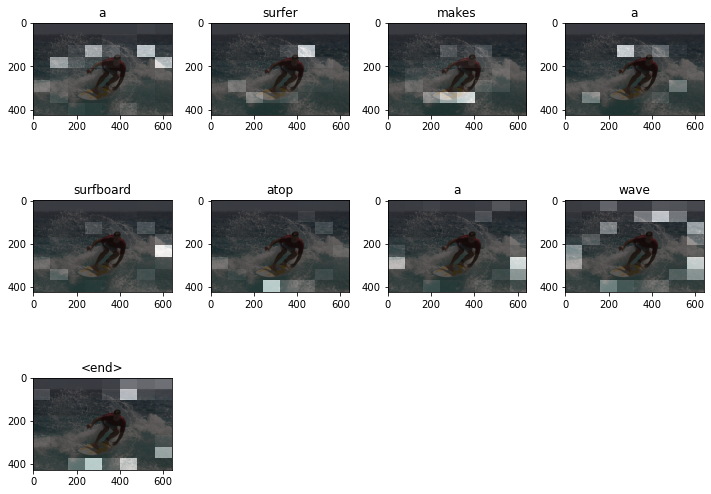

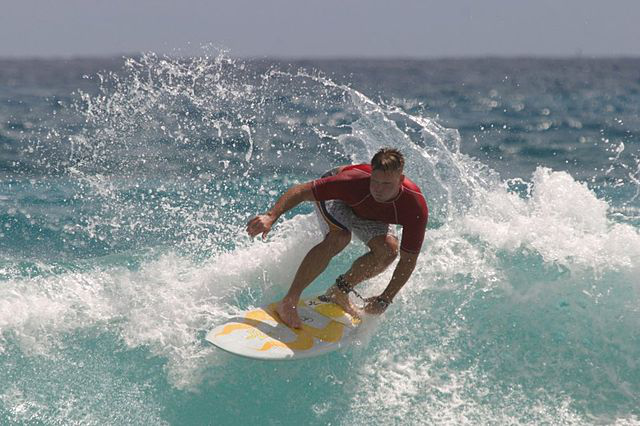

In [112]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [113]:
try:
  # %tensorflow_version only exists in Colab.
  import tensorflow.compat.v2 as tf
except Exception:
    pass
tf.enable_v2_behavior()

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#from __future__ import absolute_import, division, print_function, unicode_literals
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm.auto import tqdm
import csv
import pandas as pd

In [94]:
annotation_file = './annotations/captions_train2014.json'

PATH = './train2014'


In [95]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = os.path.join(PATH, 'COCO_train2014_' + '%012d.jpg' % (image_id))

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [96]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [97]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [98]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [114]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)


# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
#train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [ ]:
#tf-idf --not used for final submission
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform([documentA, documentB])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names)

In [115]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.0333,
                                                                    random_state=0)

In [117]:
all_captions = pd.read_csv("all_captions.csv", sep=',') 

real_captions = [x.split() for x in all_captions['true_caption'].tolist()]
pred_captions = [x.split() for x in all_captions['pred_caption'].tolist()]

In [118]:
len(pred_captions)

1000

In [119]:
import warnings
import nltk
import cv2
warnings.filterwarnings("ignore")

In [123]:
def get_similar_result_bleu(idx, real_captions, pred_captions):

    b_score_list = []

    for idx_2 in range(len(pred_captions)):
      
        b_score = nltk.translate.bleu_score.sentence_bleu([real_captions[idx]], pred_captions[idx_2])
        b_score_list.append((idx_2, b_score))

    b_score_list.sort(key=lambda x: x[1], reverse=True)

    return b_score_list

###New Function for calculating Similarity of real and predicted captions

{\displaystyle {\text{similarity}}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}

In [128]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
def get_similar_cosine(idx,real_captions,pred_captions):
    c_score_list = []
    sw = stopwords.words('english')
    for idx2 in range(len(pred_captions)):
        X_set = {w for w in real_captions[idx] if not w in sw}  
        Y_set = {w for w in pred_captions[idx2] if not w in sw} 
        l1 =[];l2 =[] 
        rvector = X_set.union(Y_set)  
        for w in rvector: 
            if w in X_set: l1.append(1) # create a vector 
            else: l1.append(0) 
            if w in Y_set: l2.append(1) 
            else: l2.append(0) 
        c = 0
        # cosine formula  
        for i in range(len(rvector)): 
                c+= l1[i]*l2[i] 
        cosine = c / float((sum(l1)*sum(l2))**0.5) 
        c_score_list.append((idx2,cosine))
    c_score_list.sort(key=lambda x:x[1],reverse = True)
    return c_score_list

In [129]:
def create_submission_file(top_k, img_name_val, real_captions, pred_captions):

    with open('./submission_bleu.csv', 'w') as file:
        writer = csv.writer(file)
        writer.writerow(["caption", "image_list"])

        for idx in tqdm(range(len(img_name_val))):

            b_score_res = get_similar_cosine(idx, real_captions, pred_captions)

            writer.writerow([' '.join(real_captions[idx]), ' '.join(list(map(lambda x: str(x[0]), b_score_res[:top_k])))])

In [130]:
create_submission_file(len(img_name_val), img_name_val, real_captions, pred_captions)

In [ ]:
#The Final submission is made with cosine similarity function with all the stop words and organised 